<a href="https://colab.research.google.com/github/TeddyAbraham/ola/blob/main/Ola_BCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1 style="text-align:center;color:#05368B;font-size: 100px; font-weight: bold;">OLA - Business Case Study</h1></center>


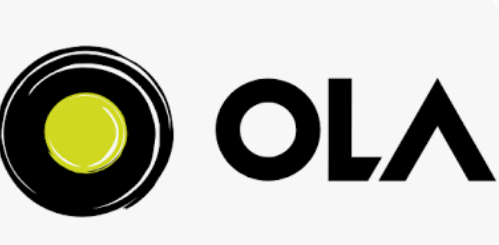

### Problem Statement:
Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

## Column Profiling:

- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a
- month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/ola_driver_scaler.csv'

_data = pd.read_csv(file_path)
_data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [ ]:
print("The shape of the data is : ",_data.shape)
print()
_data.info()

The shape of the data is :  (19104, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), obje

In [ ]:
_data=_data.drop(columns='Unnamed: 0')

In [ ]:
##Converting to datetime type
_data['MMM-YY'] = pd.to_datetime(_data['MMM-YY'])
_data['Dateofjoining'] = pd.to_datetime(_data['Dateofjoining'])
_data['LastWorkingDate'] = pd.to_datetime(_data['LastWorkingDate'])

## Missing Value Treatement


In [ ]:
missing_percentage = _data.isnull().sum() / len(_data) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Keep only columns with missing values
print(missing_percentage)

Age                 0.319305
Gender              0.272194
LastWorkingDate    91.541039
dtype: float64


Insights
- Since 91% drivers are still working so no LastWorkingDate.

In [ ]:
_data['Gender'].value_counts()

,count
Gender,
0.0,11074
1.0,7978


## KNN Imputation

In [ ]:
_data_nums=_data.select_dtypes(np.number)
_data_nums.head()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,2,57387,1,1,2381060,2
1,1,28.0,0.0,2,57387,1,1,-665480,2
2,1,28.0,0.0,2,57387,1,1,0,2
3,2,31.0,0.0,2,67016,2,2,0,1
4,2,31.0,0.0,2,67016,2,2,0,1


In [ ]:
_data_nums.drop(columns='Driver_ID',inplace=True)
columns=_data_nums.columns

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean',)
imputer.fit(_data_nums)
# transform the dataset
_data_new = imputer.transform(_data_nums)

In [ ]:
_data_new=pd.DataFrame(_data_new)
_data_new.columns = columns
_data_new.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0


In [ ]:
_data_new.isnull().sum()

,0
Age,0
Gender,0
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Total Business Value,0
Quarterly Rating,0


### Getting the remaining columns back

In [ ]:
remaining_columns=list(set(_data.columns).difference(set(columns)))

data=pd.concat([_data_new, _data[remaining_columns]],axis=1)
data.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,MMM-YY,City,Driver_ID,Dateofjoining,LastWorkingDate
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,2019-01-01,C23,1,2018-12-24,NaT
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,2019-02-01,C23,1,2018-12-24,NaT
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2019-03-01,C23,1,2018-12-24,2019-03-11
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-11-01,C7,2,2020-11-06,NaT
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-12-01,C7,2,2020-11-06,NaT


In [ ]:
data[data['Driver_ID']==20]

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,MMM-YY,City,Driver_ID,Dateofjoining,LastWorkingDate
68,26.0,1.0,0.0,40342.0,3.0,3.0,0.0,1.0,2019-10-01,C19,20,2019-10-25,NaT
69,26.0,1.0,0.0,40342.0,3.0,3.0,0.0,1.0,2019-11-01,C19,20,2019-10-25,NaT
70,26.0,1.0,0.0,40342.0,3.0,3.0,0.0,1.0,2019-12-01,C19,20,2019-10-25,NaT
71,26.0,1.0,0.0,40342.0,3.0,3.0,0.0,1.0,2020-01-01,C19,20,2019-10-25,NaT
72,26.0,1.0,0.0,40342.0,3.0,3.0,0.0,1.0,2020-02-01,C19,20,2019-10-25,NaT
73,26.0,1.0,0.0,40342.0,3.0,3.0,0.0,1.0,2020-03-01,C19,20,2019-10-25,2020-03-01


In [ ]:
_data[_data['Driver_ID']==20]

In [ ]:
function_dict = {'Age':'max', 'Gender':'first','City':'last',
                 'Education_Level':'last', 'Income':'last',
                 'Joining Designation':'last','Grade':'last',
                 'Dateofjoining':'last','LastWorkingDate':'last',
                 'Total Business Value':'sum','Quarterly Rating':'last'}
new_train=data.groupby(['Driver_ID','MMM-YY']).aggregate(function_dict)
new_train

In [ ]:
df=new_train.sort_index( ascending=[True,True])
df.head()

In [ ]:
df1=pd.DataFrame()

df1['Driver_ID']=data['Driver_ID'].unique()
df1.head()

In [ ]:
df1['Age'] = list(df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
df1['Gender'] = list(df.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
df1['City'] = list(df.groupby('Driver_ID').agg({'City':'last'})['City'])
df1['Education'] = list(df.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
df1['Income'] = list(df.groupby('Driver_ID').agg({'Income':'last'})['Income'])
df1['Joining_Designation'] = list(df.groupby('Driver_ID').agg({'Joining Designation':'last'})['Joining Designation'])
df1['Grade'] = list(df.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
df1['Total_Business_Value'] = list(df.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])
df1['Last_Quarterly_Rating'] = list(df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating'])

df1.head()

Creating a column to check if the quarterly rating has increased for that employee  
for those whose quarterly rating has increased we assign the value 1 else 0

In [ ]:
#Quarterly rating at the beginning
qrf = df.groupby('Driver_ID').agg({'Quarterly Rating':'first'})

#Quarterly rating at the end
qrl = df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})

#The dataset which has the employee ids and a bollean value which tells if the rating has increased
qr = (qrl['Quarterly Rating']>qrf['Quarterly Rating']).reset_index()

#the employee ids whose rating has increased
empid = qr[qr['Quarterly Rating']==True]['Driver_ID']

qri = []
for i in df1['Driver_ID']:
    if i in empid.values:  # changed -- instead of empid--> empid.values
        qri.append(1)
    else:
        qri.append(0)

df1['Quarterly_Rating_Increased'] = qri

In [ ]:
df1['Quarterly_Rating_Increased'].value_counts()

Only 358 drivers has got their rating increase, the remaining 2023 drivers have either same Quarterly rating or that might have even decreased from their 1st rating to their last

In [ ]:
df1.tail()

1. Creating a column called target which tells if the person has left the company
2. Persons who have a last working date will have the value 1
3. The dataset which has the employee ids and specifies if last working date is null and the employee ids who do not have last working date are assigned 0.

In [ ]:
lwr = (df.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()

#The employee ids who do not have last working date
empid = lwr[lwr['LastWorkingDate']==True]['Driver_ID']

target = []
for i in df1['Driver_ID']:
    if i in empid.values:
        target.append(0)
    elif i not in empid.values:
        target.append(1)

df1['Target'] = target
df1.head()

In [ ]:
df1['Target'].value_counts()

1616 Drivers have left the company, 765 are

Creating a column which tells if the monthly income has increased for that employee
for those whose monthly income has increased we assign the value 1

In [ ]:
#Quarterly rating at the beginning
sf = df.groupby('Driver_ID').agg({'Income':'first'})

#Quarterly rating at the end
sl = df.groupby('Driver_ID').agg({'Income':'last'})

#The dataset which has the employee ids and a bollean value which tells if the monthly income has increased
s = (sl['Income']>sf['Income']).reset_index()

#the employee ids whose monthly income has increased
empid = s[s['Income']==True]['Driver_ID']

si = []
for i in df1['Driver_ID']:
    if i in empid.values:
        si.append(1)
    else:
        si.append(0)

df1['Income_Increased'] = si


In [ ]:
df1['Income_Increased'].value_counts()

Summary

In [ ]:
df1.describe()

There are 2381 employees in the dataset.<br>
The minimum age of the employee in the data is 21 years and the maximum age is 58 years. <br>
75% of the employees have their monthly income less than or equal to 75,986 units.<br>
50% of the employees have acquired 8,17,680 as the their total business value.

In [ ]:
df1.describe(include='object')

In [ ]:
df1['Target'].value_counts()

There are total 768 drivers who have not left in cimparing with the 1616 dirvers who have left (This values does not lead to any conclusion as at this point it does not clarifies on the duration or other factors, like the drivers who have not left might have joined recently and few of the drivers who have left may have worked for longer duration ,and may have multiple other factors for leaving)

In [ ]:
print(df1['Target'].value_counts(normalize=True)*100)
df1['Target'].value_counts(normalize=True).plot(kind = 'bar' )

Around 68% employees have left the organization

In [ ]:
# List of columns to plot
n = ['Gender', 'Education', 'Joining_Designation', 'Last_Quarterly_Rating', 'Quarterly_Rating_Increased', 'Income_Increased']

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 9))  # 2 rows, 3 columns

# Flatten the axes for easy indexing
axes = axes.flatten()

# Loop through the list and plot on respective subplot
for idx, col in enumerate(n):
    ax = axes[idx]  # Select subplot
    plot = sns.countplot(data=df1, x=col, palette="viridis", ax=ax)  # Count plot

    # Calculate total count for the column
    total = len(df1[col])

    # Annotate bars with count values and percentages
    for p in ax.patches:
        count = p.get_height()
        if count > 0:
            percentage = (count / total) * 100

            # Determine position and font size dynamically
            if count < 400:  # For smaller bars
                ax.text(p.get_x() + p.get_width() / 2, count + 2,  # Slightly above the bar
                        f'{count}\n({percentage:.1f}%)',
                        ha='center', fontsize=8, color='black')
            else:  # For larger bars
                ax.text(p.get_x() + p.get_width() / 2, count - 0.1 * count,  # Inside the bar
                        f'{count}',
                        ha='center', fontsize=8, color='white', weight='bold')
                ax.text(p.get_x() + p.get_width() / 2, count + 2,  # Above the bar
                        f'({percentage:.1f}%)',
                        ha='center', fontsize=9, color='black')

    # Set title and labels
    ax.set_title(f'Count Plot for {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Preprocess data: Calculate counts and sort by value
city_counts = df1['City'].value_counts().sort_values(ascending=False)  # Descending order
sorted_cities = city_counts.index  # Sorted city names

# Create the sorted countplot
plt.figure(figsize=(15, 4))
ax = sns.countplot(data=df1, x='City', palette="viridis", order=sorted_cities)  # Use `order` to sort

# Calculate total count for the column
total = len(df1['City'])

# Annotate bars with value and percentage
for p in ax.patches:
    count = p.get_height()  # Get the height of each bar
    if count > 0:  # Skip bars with zero height
        percentage = (count / total) * 100  # Calculate percentage

        # Annotate value (top)
        ax.text(p.get_x() + p.get_width() / 2, count - (count * 0.1),
                f'{count:.0f}', ha='center', fontsize=10, color='white', weight='bold')

        # Annotate percentage (below value or above for small bars)
        ax.text(p.get_x() + p.get_width() / 2, count + 2,
                f'({percentage:.1f}%)', ha='center', fontsize=10, color='black')

# Add labels and title
ax.set_title('Count Plot for City (Sorted by Count)', fontsize=14)
ax.set_xlabel('City', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

1400 employees are of the Male gender and 977 are females.<br>
152 employees are from city C20 and 101 from city C15.<br>
802 employees have their education as Graduate and 795 have completed their 12.<br>
1026 employees had their joining designation as 1 at the time of reporting.<br>
1744 employees had their last quarterly rating as 1.<br>
The quarterly rating has not increased for 2023 employees.

Around 59% employees are of the Male gender.<br>
Around 6.4% employees are from city C20 and 4.2% from city C15.<br>
The proportion of the employees who have completed their Graduate and 12th is approximately same.<br>
At the time of reporting, 43% of the employees had their grade as 1 and .05% had grade as 5.<br>
Around 73% of the employees had their last quarterly rating as 1.<br>
The quarterly rating has not increased for around 85% employees.

In [ ]:
plt.subplots(figsize=(14,3))
plt.subplot(121)
sns.distplot(df1['Age'],color='green')
plt.title("Age of employees")
plt.subplot(122)
df1['Age'].plot.box(title='Boxplot of Age')
plt.tight_layout(pad=3)

In [ ]:
plt.subplots(figsize=(15,3))
plt.subplot(121)
sns.distplot(df1['Income'],color='orange')
plt.title("Income")
plt.subplot(122)
df1['Income'].plot.box(title='Boxplot of Income')
plt.tight_layout(pad=3)

In [ ]:
plt.subplots(figsize=(15,3))
plt.subplot(121)
sns.distplot(df1['Total_Business_Value'],color='indigo')
plt.title("Total Business Value")
plt.subplot(122)
df1['Total_Business_Value'].plot.box(title='Boxplot of Total Business Value')
plt.tight_layout(pad=3)

- There are few outliers in the Age. The distribution is towards the right.
- The distribution of Salary is towards the right and there are outliers for this feature as well.
- The distribution of total business value is towards the right. There are a lot of outliers for the feature Total Business Value.

In [ ]:
figure,axes=plt.subplots(2,3,figsize=(15,9))

#Gender feature with Target
gender = pd.crosstab(df1['Gender'],df1['Target'])
gender.div(gender.sum(1).astype(float),axis=0).plot(kind='bar',stacked=False,ax=axes[0,0],title="Gender with The Target")

#Education feature with Target
education = pd.crosstab(df1['Education'],df1['Target'])
education.div(education.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[0,1],
                                                          title="Education with The Target")

#Joining Designation feature with Target
jde = pd.crosstab(df1['Joining_Designation'],df1['Target'])
jde.div(jde.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[0,2],
                                                      title="Joining Designation with The Target")

#Designation feature with Target
desig = pd.crosstab(df1['Grade'],df1['Target'])
desig.div(desig.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[1,0],
                                                    title="Designation with The Target")

#Last Quarterly Rating feature with Target
lqrate = pd.crosstab(df1['Last_Quarterly_Rating'],df1['Target'])
lqrate.div(lqrate.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[1,1],
                                                      title="Last Quarterly Rating with The Target")

#Quarterly Rating Increased feature with Target
qratei = pd.crosstab(df1['Quarterly_Rating_Increased'],df1['Target'])
qratei.div(qratei.sum(1).astype(float),axis=0).plot(kind='bar',stacked=False,ax=axes[1,2],
                                                         title="Quarterly Rating Increased with the Target")

plt.tight_layout(pad=3)

- **The proportion of gender and education is more or less the same for both the employees who left the organization and those who did not leave.**
- **The employees who have their grade as 3 or 4 at the time of joining are less likely to leave the organization.**
- **The employees who have their grade as 3 or 4 at the time of reporting are less likely to leave the organization.**
- **The employees who have their last quarterly rating as 3 or 4 at the time of reporting are less likely to leave the organization.**
- **The employees whose quarterly rating has increased are less likely to leave the organization.**

In [ ]:
#City feature with the target
plt.figure(figsize=(30,7))
city = pd.crosstab(df1['City'],df1['Target'])
city.div(city.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="City with the Target")
plt.tight_layout()

In [ ]:
df1.columns

In [ ]:
x_corr = df1.drop(['Driver_ID', 'City', 'Target'], axis=1).corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(x_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

- Grade and have a positive correlation with both job_Designation and Income (i.e .71 and .74)
- Total_Business_Value and Increase in Quality Ratings also have a positively correlation.


### One Hot Encoding

Converting categorical variables to numeric values so that Machine Learning models can be applied.

In [ ]:
df1 = pd.concat([df1,pd.get_dummies(df1['City'],prefix='City')],axis=1)

Normalising the Dataset. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [ ]:
df1.head()

In [ ]:
#Feature Variables
X = df1.drop(['Driver_ID','Target','City'],axis=1)
X_cols=X.columns
# MinMaxScaler
scaler = MinMaxScaler()

#Mathematically learning the distribution
X=scaler.fit_transform(X)

In [ ]:
X=pd.DataFrame(X)

X.columns=X_cols

X.head()

In [ ]:
#Target Variable
y = df1['Target']
# split into 80:20 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 7)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

## Random Forest with class weights

In [ ]:
from sklearn.utils import class_weight

In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced')

c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

- The Random Forest With Class Weighting method out of all predicted 0 the measure of correctly predicted is 70%, and for 1 it is 82%(Precision).
- The Random Forest With Class Weighting method out of all actual 0 the measure of correctly predicted is 58%, and for 1 it is 89%(Recall).

In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced_subsample')

c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

- The Random Forest With Bootstrap Class Weighting method out of all predicted 0 the measure of correctly predicted is 69%, and for 1 it is 82%(Precision).
- The Random Forest With Bootstrap Class Weighting method out of all actual 0 the measure of correctly predicted is 58%, and for 1 it is 88%(Recall).

No Need for now ## Step-6:Balancing the dataset using SMOTE



Since the Dataset is imbalance and is biased towards target=1, so we will use SMOTE to balance the dataset

In [ ]:
from imblearn.over_sampling import SMOTE

# Create and instance of SMOTE
smt = SMOTE()

print("Before SMOTE")
y = pd.DataFrame(y)
print(y.value_counts())

X_sm, y_sm = smt.fit_resample(X, y)

print("After Oversampeling")
y_sm1 = pd.DataFrame(y_sm)
print(y_sm1.value_counts())

In [ ]:
# print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 7)
# X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

# print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

# Model Building:
Ensembling - Bagging Algorithm - Random Forest Classifier

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 7)

In [ ]:
# params = {
#     'n_estimators' : [100,200,300,400],
#     'max_depth' : [3,5,10],
#     'criterion' : ['gini', 'entropy'],
#     'bootstrap' : [True, False],
#     'max_features' : [8,9,10]
# }

In [ ]:
# from sklearn.ensemble import RandomForestClassifier as RFC
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import datetime as dt

In [ ]:
# rfc = RFC()
# clf = RandomizedSearchCV(rfc, params, scoring = 'accuracy', cv = 3, n_jobs = -1, verbose = 1)
# clf.fit(X_train, y_train)

In [ ]:
# print(clf.best_estimator_)

In [ ]:
# rfc = clf.best_estimator_
# rfc.fit(X_train, y_train)

# # Model accuracy of RFC
# print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, rfc.predict(X_test))))

# Ensemble Boosting Algorithm - GBDT

In [ ]:
# params = {
#     'n_estimators' : [50, 100, 150, 200],
#     'max_depth' : [3,5,10],
#     'max_leaf_nodes' : [3,5,10],
#     'learning_rate' : [.1,.2,.3]
# }

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier as GBC

# gbc = GBC()
# clf = RandomizedSearchCV(gbc, params, scoring = 'accuracy', cv = 3, n_jobs = -1, verbose = 1)
# clf.fit(X_train, y_train)

In [ ]:
# print(clf.best_estimator_)

In [ ]:
# gbc = clf.best_estimator_
# gbc.fit(X_train, y_train)

# # Model accuracy of GBC
# print('Model accuracy:' , gbc.score(X_test, y_test))

# Ensembling - Boostging Algorithm- XGBoost

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

# params = {
#     'n_estimators' : [50, 100, 150, 200],
#     'max_depth' : [3,5,10],
#     'subsample' : [.6, .8, 1.0],
#     'learning_rate' : [.1,.2,.3],
#     'col_sample_bytree' : [.6, .8, 1.0]
# }

# xgb = XGBClassifier()

In [ ]:
# # Use Random search CV to get the best fitting Hyperparameter for our boosting algorithm i.e, XGBoost
# random_search = RandomizedSearchCV(xgb,
#                                    params,
#                                    n_iter = 10,
#                                    scoring = 'accuracy',
#                                    cv = 3,
#                                    n_jobs = -1,
#                                    verbose = 2)

# random_search.fit(X_train,y_train)

## Random Forest Classifier

In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced')

c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

In [ ]:
pred = c.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63       148
           1       0.82      0.89      0.86       329

    accuracy                           0.79       477
   macro avg       0.76      0.73      0.74       477
weighted avg       0.79      0.79      0.79       477

[[ 85  63]
 [ 36 293]]


- The Random Forest method out of all predicted 0 the measure of correctly predicted is 72%, and for 1 it is 82%(Precision).
- The Random Forest method out of all actual 0 the measure of correctly predicted is 57%, and for 1 it is 90%(Recall).

## XGBoost Classifier


In [ ]:
import xgboost as xgb
my_model = xgb.XGBClassifier(class_weight ='balanced')
my_model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = my_model.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       148
           1       0.82      0.86      0.84       329

    accuracy                           0.77       477
   macro avg       0.73      0.71      0.72       477
weighted avg       0.76      0.77      0.76       477

[[ 84  64]
 [ 47 282]]


- The XGBoost method out of all predicted 0 the measure of correctly predicted is 60%, and for 1 it is 82%(Precision).
- The XGBoost method out of all actual 0 the measure of correctly predicted is 59%, and for 1 it is 82%(Recall).

## Decision Tree Classifier

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.55      0.53      0.54       148
           1       0.79      0.81      0.80       329

    accuracy                           0.72       477
   macro avg       0.67      0.67      0.67       477
weighted avg       0.72      0.72      0.72       477

[[ 79  69]
 [ 64 265]]


- The Decision Tree method out of all predicted 0 the measure of correctly predicted is 47%, and for 1 it is 79%(Precision).
- The Decision Tree method out of all actual 0 the measure of correctly predicted is 57%, and for 1 it is 71%(Recall).

## Step-8:Result Analysis

- We observe that we are not getting very high recall on target 0 which may be due to small unbalanced dataset.
- Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned).

## Feature Importance for the best model so far

In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest = RandomForestClassifier(class_weight ='balanced')

random_forest.fit(X_train,y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'max_depth': 4, 'n_estimators': 150}
The score is : 0.8560652129428967


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.024 seconds


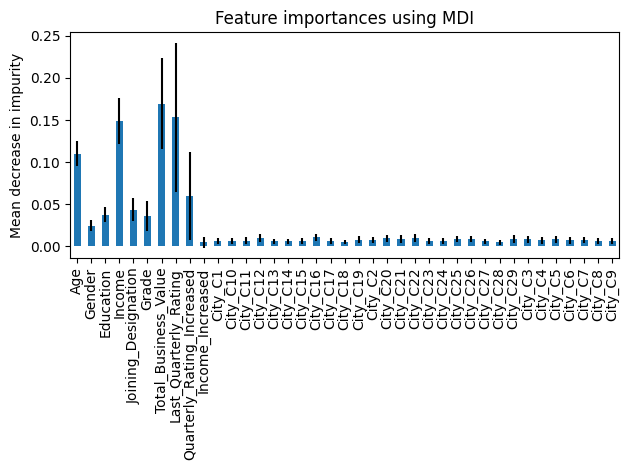

In [ ]:
import pandas as pd

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()